# DMDc Test: Controlled Linear Dynamical System

This notebook demonstrates:
1. Generating data from a controlled linear dynamical system
2. Fitting a DMDc model to recover the system matrices
3. Visualizing the eigenvalues of A and singular values of B to verify the fit


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('../')

from DSA.dmdc import DMDc

# Set random seed for reproducibility
np.random.seed(42)


## 1. Generate Ground Truth Linear Dynamical System

We'll create a controlled linear dynamical system of the form:
$$x_{t+1} = A x_t + B u_t$$

where:
- $x_t \in \mathbb{R}^n$ is the state
- $u_t \in \mathbb{R}^m$ is the control input
- $A \in \mathbb{R}^{n \times n}$ is the state transition matrix
- $B \in \mathbb{R}^{n \times m}$ is the control input matrix


In [21]:
# System dimensions
n_state = 10  # state dimension
n_control = 3  # control dimension
n_timesteps = 1000  # number of time steps
n_trials = 5  # number of trials

# Sample random matrix for A and normalize to have max eigenvalue of 0.95
A_random = np.random.randn(n_state, n_state)
eigs_A = np.linalg.eigvals(A_random)
max_eig = np.max(np.abs(eigs_A))
A_true = A_random / max_eig * 0.95

# Sample random matrix for B
B_true = np.random.randn(n_state, n_control)

# Compute actual eigenvalues and singular values
eigenvalues_A = np.linalg.eigvals(A_true)
singular_values_B = np.linalg.svd(B_true, compute_uv=False)

print(f"Ground truth A eigenvalues: {eigenvalues_A}")
print(f"Ground truth B singular values: {singular_values_B}")
print(f"\nA matrix spectral radius: {np.max(np.abs(eigenvalues_A)):.4f}")
print(f"System is stable: {np.max(np.abs(eigenvalues_A)) < 1}")


Ground truth A eigenvalues: [-0.87865666+0.3611959j  -0.87865666-0.3611959j  -0.63342513+0.09350672j
 -0.63342513-0.09350672j  0.50029664+0.40533415j  0.50029664-0.40533415j
  0.50450346+0.10018783j  0.50450346-0.10018783j  0.18230014+0.j
 -0.14354022+0.j        ]
Ground truth B singular values: [3.3561271  2.53100558 1.62794133]

A matrix spectral radius: 0.9500
System is stable: True


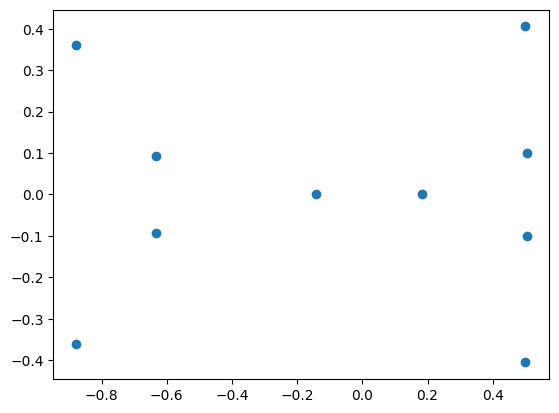

In [22]:
eigs = np.linalg.eigvals(A_true)
plt.scatter(eigs.real,eigs.imag)

## 2. Generate Data from the System


In [24]:
def generate_controlled_trajectory(A, B, n_timesteps, n_trials, noise_std=0.01):
    """
    Generate data from a controlled linear dynamical system.
    
    Parameters:
    -----------
    A : ndarray (n_state, n_state)
        State transition matrix
    B : ndarray (n_state, n_control)
        Control input matrix
    n_timesteps : int
        Number of time steps per trial
    n_trials : int
        Number of trials
    noise_std : float
        Standard deviation of process noise
    
    Returns:
    --------
    X : ndarray (n_trials, n_timesteps, n_state)
        State trajectories
    U : ndarray (n_trials, n_timesteps, n_control)
        Control inputs
    """
    n_state = A.shape[0]
    n_control = B.shape[1]
    
    X = np.zeros((n_trials, n_timesteps, n_state))
    U = np.zeros((n_trials, n_timesteps, n_control))
    
    for trial in range(n_trials):
        # Initialize with random state
        X[trial, 0] = np.random.randn(n_state) * 0.1
        
        # Generate control inputs (random walk with some structure)
        U[trial] = np.cumsum(np.random.randn(n_timesteps, n_control) * 0.1, axis=0)
        
        # Simulate system
        for t in range(n_timesteps - 1):
            # x_{t+1} = A x_t + B u_t + noise
            X[trial, t + 1] = (A @ X[trial, t] + 
                               B @ U[trial, t] + 
                               np.random.randn(n_state) * noise_std)
    
    return X, U

# Generate training data
X_train, U_train = generate_controlled_trajectory(A_true, B_true, n_timesteps, n_trials)

print(f"Generated data shape:")
print(f"  State data X: {X_train.shape}")
print(f"  Control data U: {U_train.shape}")


Generated data shape:
  State data X: (5, 1000, 10)
  Control data U: (5, 1000, 3)


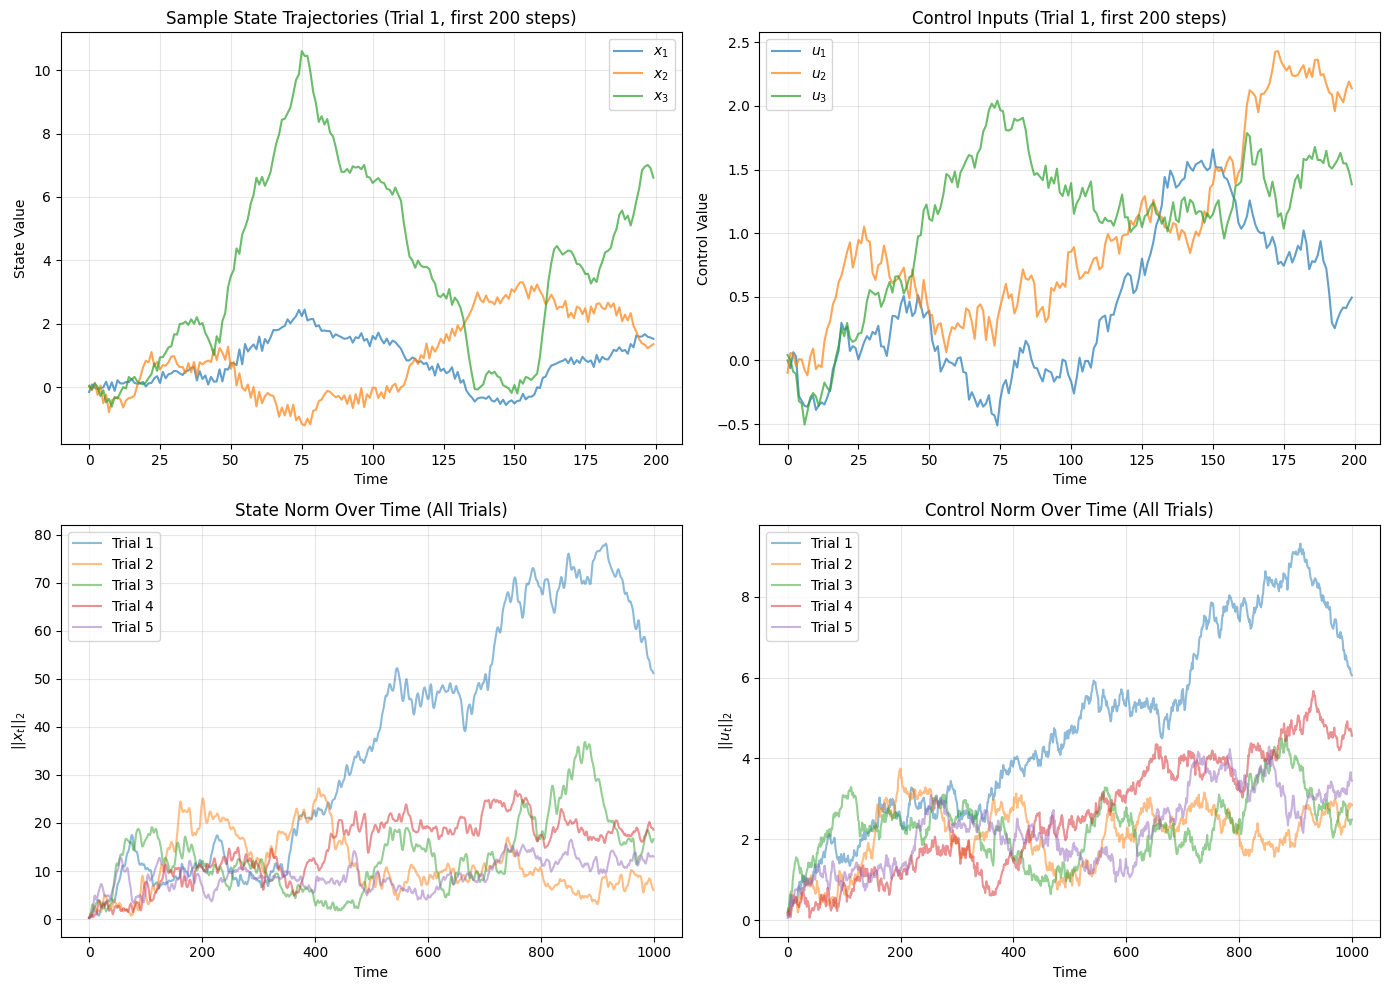

In [25]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot first few state dimensions
ax = axes[0, 0]
for i in range(min(3, n_state)):
    ax.plot(X_train[0, :200, i], label=f'$x_{{{i+1}}}$', alpha=0.7)
ax.set_xlabel('Time')
ax.set_ylabel('State Value')
ax.set_title('Sample State Trajectories (Trial 1, first 200 steps)')
ax.legend()
ax.grid(True, alpha=0.3)

# Plot control inputs
ax = axes[0, 1]
for i in range(n_control):
    ax.plot(U_train[0, :200, i], label=f'$u_{{{i+1}}}$', alpha=0.7)
ax.set_xlabel('Time')
ax.set_ylabel('Control Value')
ax.set_title('Control Inputs (Trial 1, first 200 steps)')
ax.legend()
ax.grid(True, alpha=0.3)

# Plot state norm over time
ax = axes[1, 0]
for trial in range(n_trials):
    state_norm = np.linalg.norm(X_train[trial], axis=1)
    ax.plot(state_norm, alpha=0.5, label=f'Trial {trial+1}')
ax.set_xlabel('Time')
ax.set_ylabel('$||x_t||_2$')
ax.set_title('State Norm Over Time (All Trials)')
ax.legend()
ax.grid(True, alpha=0.3)

# Plot control norm over time
ax = axes[1, 1]
for trial in range(n_trials):
    control_norm = np.linalg.norm(U_train[trial], axis=1)
    ax.plot(control_norm, alpha=0.5, label=f'Trial {trial+1}')
ax.set_xlabel('Time')
ax.set_ylabel('$||u_t||_2$')
ax.set_title('Control Norm Over Time (All Trials)')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


## 4. Fit DMDc Model


In [ ]:
# Create and fit DMDc model
dmdc = DMDc(
    data=X_train,
    control_data=U_train,
    n_delays=1,
    n_control_delays=1,
    delay_interval=1,
    rank_input=None,  
    rank_output=None,  
    lamb=0, 
    device='cpu',
    verbose=True
)

# Fit the model
dmdc.fit()

print("\nDMDc model fitted successfully!")
print(f"Recovered A matrix shape: {dmdc.A.shape}")
print(f"Recovered B matrix shape: {dmdc.B.shape}")


Computing Hankel matrices ...
Hankel matrices computed!
Computing SVD on H and U matrices ...
SVDs computed!
Computing DMDc matrices ...
DMDc matrices computed!

DMDc model fitted successfully!
Recovered A matrix shape: torch.Size([10, 10])
Recovered B matrix shape: torch.Size([10, 3])


## 5. Compare True vs Recovered Matrices

### 5.1 Eigenvalues of A


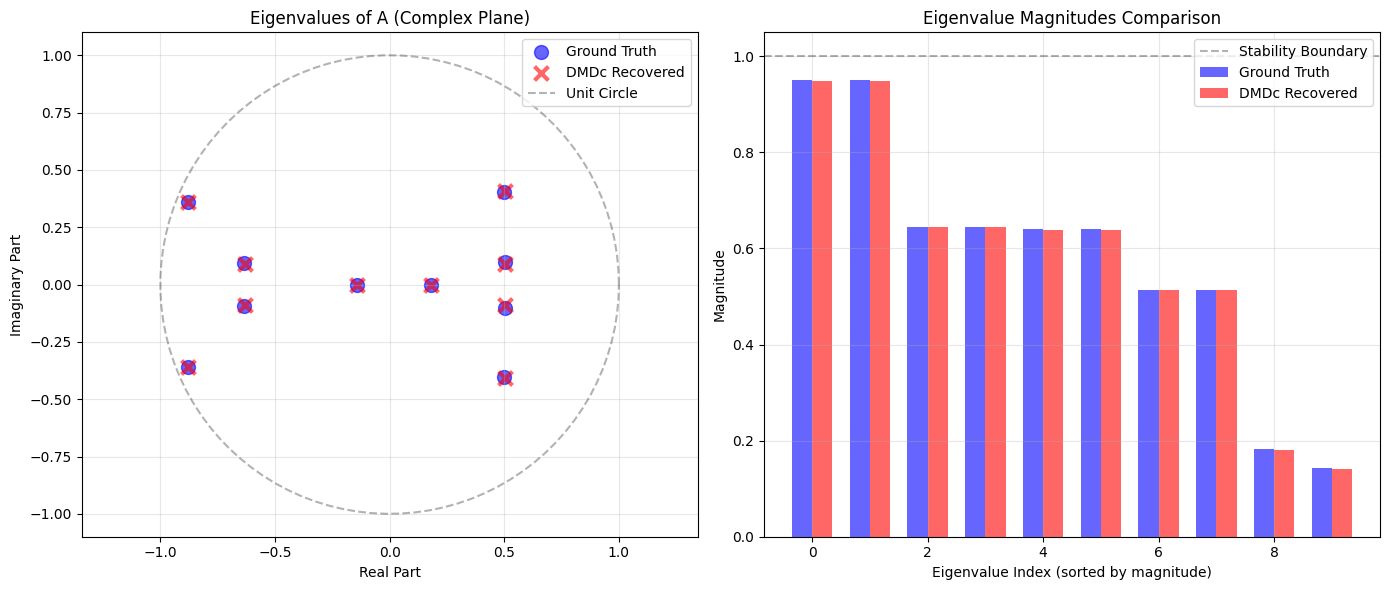


Eigenvalue Comparison (sorted by magnitude):
Index    True                      Recovered                 Error     
0        -0.8787-0.3612j           -0.8780-0.3617j           0.000828  
1        -0.8787+0.3612j           -0.8780+0.3617j           0.000828  
2        0.5003-0.4053j            0.5015-0.4058j            0.001296  
3        0.5003+0.4053j            0.5015+0.4058j            0.001296  
4        -0.6334-0.0935j           -0.6324-0.0882j           0.005358  
5        -0.6334+0.0935j           -0.6324+0.0882j           0.005358  
6        0.5045-0.1002j            0.5048-0.0906j            0.009595  
7        0.5045+0.1002j            0.5048+0.0906j            0.009595  
8        0.1823                    0.1814                    0.000874  
9        -0.1435                   -0.1413                   0.002219  


In [27]:
# Compute eigenvalues
A_recovered = dmdc.A.cpu().numpy() if hasattr(dmdc.A, 'cpu') else dmdc.A
eigenvalues_A_recovered = np.linalg.eigvals(A_recovered)

# Sort eigenvalues by magnitude for easier comparison
idx_true = np.argsort(np.abs(eigenvalues_A))[::-1]
idx_recovered = np.argsort(np.abs(eigenvalues_A_recovered))[::-1]

eigenvalues_A_sorted = eigenvalues_A[idx_true]
eigenvalues_A_recovered_sorted = eigenvalues_A_recovered[idx_recovered]

# Plot eigenvalues in complex plane
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Complex plane plot
ax = axes[0]
ax.scatter(eigenvalues_A.real, eigenvalues_A.imag, 
          s=100, alpha=0.6, label='Ground Truth', marker='o', color='blue')
ax.scatter(eigenvalues_A_recovered.real, eigenvalues_A_recovered.imag, 
          s=100, alpha=0.6, label='DMDc Recovered', marker='x', color='red', linewidths=3)

# Draw unit circle
theta = np.linspace(0, 2*np.pi, 100)
ax.plot(np.cos(theta), np.sin(theta), 'k--', alpha=0.3, label='Unit Circle')

ax.set_xlabel('Real Part')
ax.set_ylabel('Imaginary Part')
ax.set_title('Eigenvalues of A (Complex Plane)')
ax.legend()
ax.grid(True, alpha=0.3)
ax.axis('equal')

# Magnitude comparison
ax = axes[1]
x_pos = np.arange(len(eigenvalues_A))
width = 0.35
ax.bar(x_pos - width/2, np.abs(eigenvalues_A_sorted), width, 
       alpha=0.6, label='Ground Truth', color='blue')
ax.bar(x_pos + width/2, np.abs(eigenvalues_A_recovered_sorted), width, 
       alpha=0.6, label='DMDc Recovered', color='red')
ax.axhline(y=1, color='k', linestyle='--', alpha=0.3, label='Stability Boundary')
ax.set_xlabel('Eigenvalue Index (sorted by magnitude)')
ax.set_ylabel('Magnitude')
ax.set_title('Eigenvalue Magnitudes Comparison')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print numerical comparison
print("\nEigenvalue Comparison (sorted by magnitude):")
print("="*70)
print(f"{'Index':<8} {'True':<25} {'Recovered':<25} {'Error':<10}")
print("="*70)
for i in range(len(eigenvalues_A)):
    error = np.abs(eigenvalues_A_sorted[i] - eigenvalues_A_recovered_sorted[i])
    true_str = f"{eigenvalues_A_sorted[i].real:.4f}"
    if np.abs(eigenvalues_A_sorted[i].imag) > 1e-10:
        true_str += f"+{eigenvalues_A_sorted[i].imag:.4f}j" if eigenvalues_A_sorted[i].imag > 0 else f"{eigenvalues_A_sorted[i].imag:.4f}j"
    rec_str = f"{eigenvalues_A_recovered_sorted[i].real:.4f}"
    if np.abs(eigenvalues_A_recovered_sorted[i].imag) > 1e-10:
        rec_str += f"+{eigenvalues_A_recovered_sorted[i].imag:.4f}j" if eigenvalues_A_recovered_sorted[i].imag > 0 else f"{eigenvalues_A_recovered_sorted[i].imag:.4f}j"
    print(f"{i:<8} {true_str:<25} {rec_str:<25} {error:<10.6f}")
print("="*70)


### 5.2 Singular Values of B


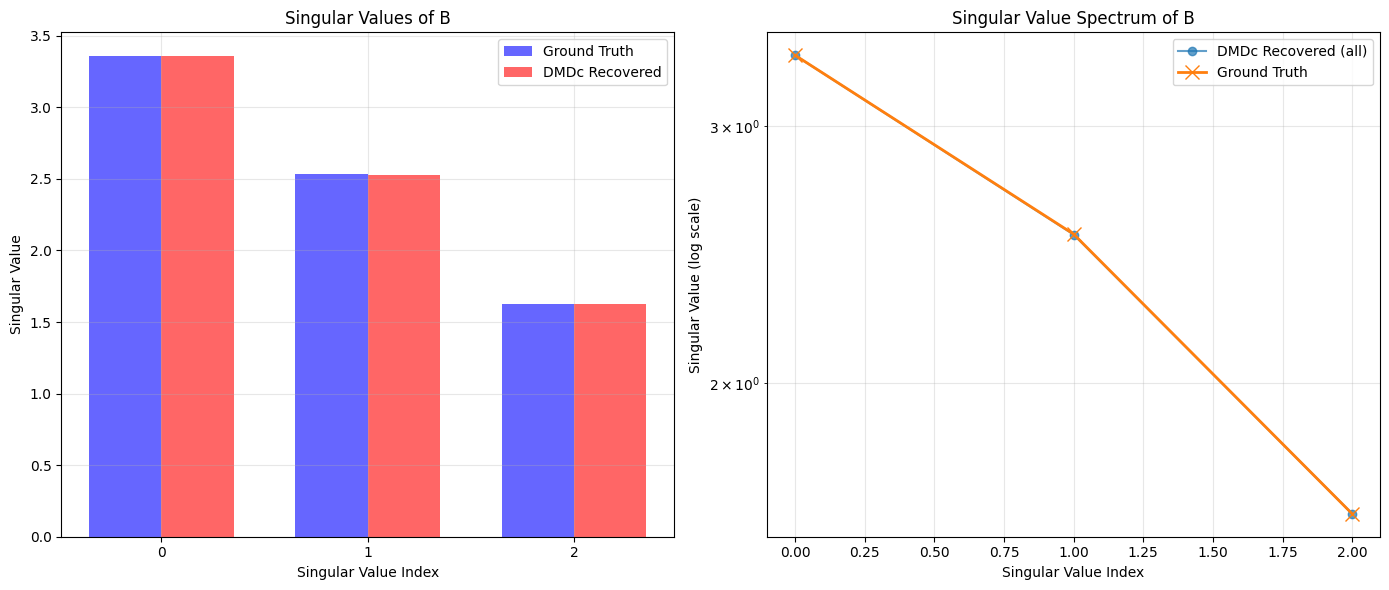


Singular Value Comparison:
Index    True            Recovered       Relative Error 
0        3.356127        3.355637        0.000146       
1        2.531006        2.529212        0.000709       
2        1.627941        1.628247        0.000188       


In [28]:
# Compute singular values
B_recovered = dmdc.B.cpu().numpy() if hasattr(dmdc.B, 'cpu') else dmdc.B
singular_values_B_recovered = np.linalg.svd(B_recovered, compute_uv=False)

# Plot singular values
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Bar plot comparison
ax = axes[0]
x_pos = np.arange(len(singular_values_B))
width = 0.35
ax.bar(x_pos - width/2, singular_values_B, width, 
       alpha=0.6, label='Ground Truth', color='blue')
ax.bar(x_pos + width/2, singular_values_B_recovered[:len(singular_values_B)], width, 
       alpha=0.6, label='DMDc Recovered', color='red')
ax.set_xlabel('Singular Value Index')
ax.set_ylabel('Singular Value')
ax.set_title('Singular Values of B')
ax.set_xticks(x_pos)
ax.legend()
ax.grid(True, alpha=0.3)

# Log scale plot (if needed for wide range)
ax = axes[1]
ax.semilogy(singular_values_B_recovered, 'o-', label='DMDc Recovered (all)', alpha=0.7)
ax.semilogy(range(len(singular_values_B)), singular_values_B, 'x-', 
           label='Ground Truth', markersize=10, linewidth=2)
ax.set_xlabel('Singular Value Index')
ax.set_ylabel('Singular Value (log scale)')
ax.set_title('Singular Value Spectrum of B')
ax.legend()
ax.grid(True, alpha=0.3, which='both')

plt.tight_layout()
plt.show()

# Print numerical comparison
print("\nSingular Value Comparison:")
print("="*60)
print(f"{'Index':<8} {'True':<15} {'Recovered':<15} {'Relative Error':<15}")
print("="*60)
for i in range(len(singular_values_B)):
    rel_error = np.abs(singular_values_B[i] - singular_values_B_recovered[i]) / singular_values_B[i]
    print(f"{i:<8} {singular_values_B[i]:<15.6f} {singular_values_B_recovered[i]:<15.6f} {rel_error:<15.6f}")
print("="*60)


## 6. Prediction Performance

Let's verify that the model can accurately predict future states.


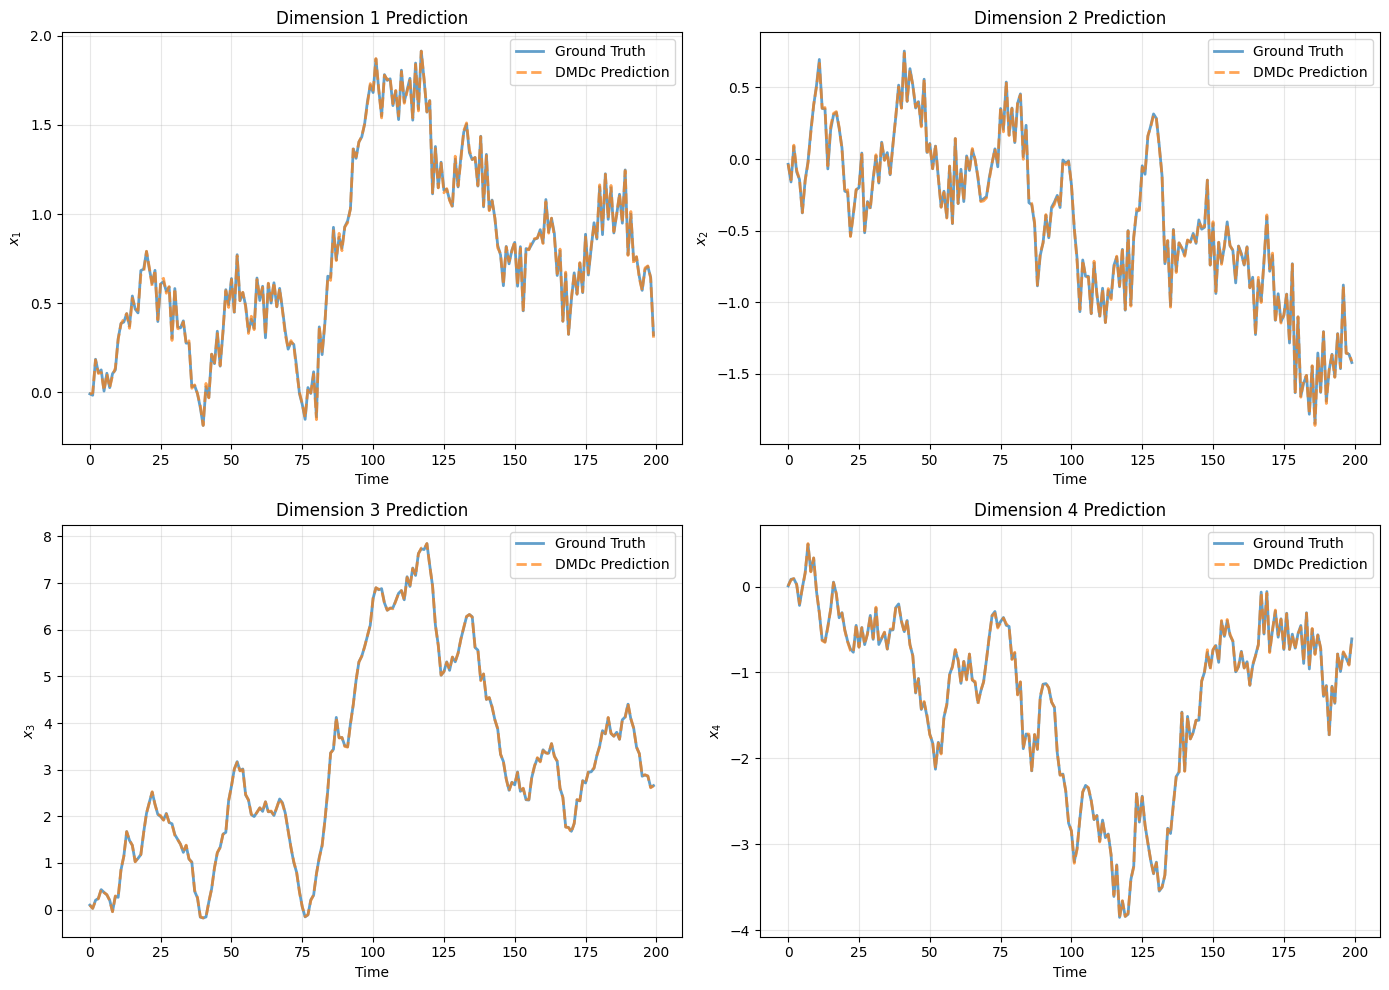

{'MAE': 0.0080215854461753,
 'MASE': 0.03452452148384243,
 'NMSE': 2.7266879462026973e-06,
 'MSE': 0.00010147284380389543,
 'R2': 0.9999937456506395,
 'Correl': 0.9999968409538269,
 'AIC': -9.175519344010073,
 'logMSE': -9.195719344010072}

In [32]:
from DSA import compute_all_stats
# Generate test data
X_test, U_test = generate_controlled_trajectory(A_true, B_true, n_timesteps=500, n_trials=2)

# Make predictions
X_pred = dmdc.predict(test_data=X_test, control_data=U_test, reseed=1)
X_pred_np = X_pred.cpu().numpy() if hasattr(X_pred, 'cpu') else X_pred


# Plot predictions vs ground truth
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

trial_idx = 0  # Plot first trial
time_window = slice(0, 200)

# Plot first few dimensions
for dim_idx in range(min(4, n_state)):
    ax = axes[dim_idx // 2, dim_idx % 2]
    ax.plot(X_test[trial_idx, time_window, dim_idx], 
           label='Ground Truth', linewidth=2, alpha=0.7)
    ax.plot(X_pred_np[trial_idx, time_window, dim_idx], 
           label='DMDc Prediction', linewidth=2, linestyle='--', alpha=0.7)
    ax.set_xlabel('Time')
    ax.set_ylabel(f'$x_{{{dim_idx+1}}}$')
    ax.set_title(f'Dimension {dim_idx+1} Prediction')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()



compute_all_stats(X_test, X_pred,rank=dmdc.A.shape[0])

## 7. Matrix Reconstruction Error

Let's compute how well we recovered the A and B matrices.



Matrix Reconstruction Errors:
A Matrix:
  Frobenius Norm Error: 0.023059
  Relative Error: 0.008991 (0.90%)

B Matrix:
  Frobenius Norm Error: 0.008771
  Relative Error: 0.001946 (0.19%)


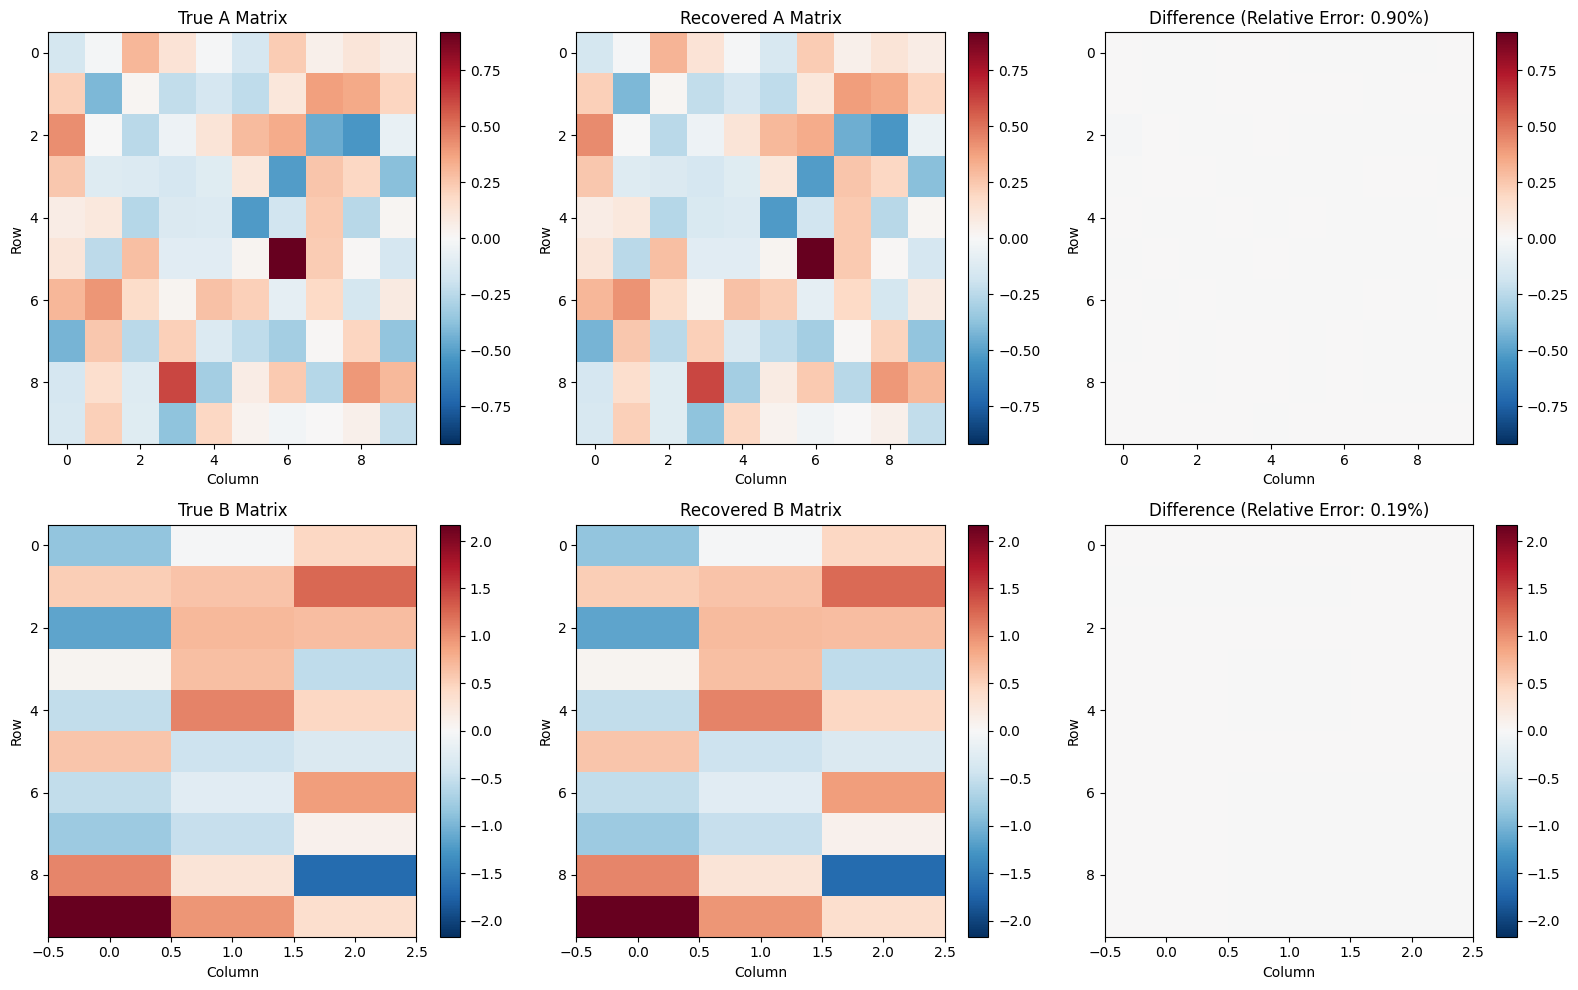

In [33]:
A_frobenius_error = np.linalg.norm(A_true - A_recovered, 'fro')
A_relative_error = A_frobenius_error / np.linalg.norm(A_true, 'fro')

B_frobenius_error = np.linalg.norm(B_true - B_recovered, 'fro')
B_relative_error = B_frobenius_error / np.linalg.norm(B_true, 'fro')

print("\nMatrix Reconstruction Errors:")
print("="*60)
print(f"A Matrix:")
print(f"  Frobenius Norm Error: {A_frobenius_error:.6f}")
print(f"  Relative Error: {A_relative_error:.6f} ({A_relative_error*100:.2f}%)")
print(f"\nB Matrix:")
print(f"  Frobenius Norm Error: {B_frobenius_error:.6f}")
print(f"  Relative Error: {B_relative_error:.6f} ({B_relative_error*100:.2f}%)")
print("="*60)

# Visualize matrix differences
fig, axes = plt.subplots(2, 3, figsize=(16, 10))

# A matrix visualization
vmax_A = max(np.abs(A_true).max(), np.abs(A_recovered).max())
im0 = axes[0, 0].imshow(A_true, cmap='RdBu_r', vmin=-vmax_A, vmax=vmax_A, aspect='auto')
axes[0, 0].set_title('True A Matrix')
axes[0, 0].set_xlabel('Column')
axes[0, 0].set_ylabel('Row')
plt.colorbar(im0, ax=axes[0, 0])

im1 = axes[0, 1].imshow(A_recovered, cmap='RdBu_r', vmin=-vmax_A, vmax=vmax_A, aspect='auto')
axes[0, 1].set_title('Recovered A Matrix')
axes[0, 1].set_xlabel('Column')
axes[0, 1].set_ylabel('Row')
plt.colorbar(im1, ax=axes[0, 1])

A_diff = A_true - A_recovered
im2 = axes[0, 2].imshow(A_diff, cmap='RdBu_r', vmin=-vmax_A, vmax=vmax_A, aspect='auto')
axes[0, 2].set_title(f'Difference (Relative Error: {A_relative_error*100:.2f}%)')
axes[0, 2].set_xlabel('Column')
axes[0, 2].set_ylabel('Row')
plt.colorbar(im2, ax=axes[0, 2])

# B matrix visualization
vmax_B = max(np.abs(B_true).max(), np.abs(B_recovered).max())
im3 = axes[1, 0].imshow(B_true, cmap='RdBu_r', vmin=-vmax_B, vmax=vmax_B, aspect='auto')
axes[1, 0].set_title('True B Matrix')
axes[1, 0].set_xlabel('Column')
axes[1, 0].set_ylabel('Row')
plt.colorbar(im3, ax=axes[1, 0])

im4 = axes[1, 1].imshow(B_recovered, cmap='RdBu_r', vmin=-vmax_B, vmax=vmax_B, aspect='auto')
axes[1, 1].set_title('Recovered B Matrix')
axes[1, 1].set_xlabel('Column')
axes[1, 1].set_ylabel('Row')
plt.colorbar(im4, ax=axes[1, 1])

B_diff = B_true - B_recovered
im5 = axes[1, 2].imshow(B_diff, cmap='RdBu_r', vmin=-vmax_B, vmax=vmax_B, aspect='auto')
axes[1, 2].set_title(f'Difference (Relative Error: {B_relative_error*100:.2f}%)')
axes[1, 2].set_xlabel('Column')
axes[1, 2].set_ylabel('Row')
plt.colorbar(im5, ax=axes[1, 2])

plt.tight_layout()
plt.show()


## Summary

This notebook demonstrated:

1. **Data Generation**: Created a controlled linear dynamical system with known eigenvalues of A and singular values of B
2. **Model Fitting**: Successfully fit a DMDc model to recover the system matrices
3. **Verification**: Compared the recovered eigenvalues and singular values with ground truth
4. **Prediction**: Tested the model's ability to predict future states

The results show that DMDc can accurately recover the dynamics of a controlled linear system from data, with the eigenvalues and singular values closely matching the ground truth values.
